In [2]:
import torch, os
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time
import datetime
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tqdm.auto import tqdm
import copy
import matplotlib.pyplot as plt
import seaborn as sns

## Chest Xray Pneumonia

In [3]:
def load_img_paths(type_data, based_dir):
    result = []
    
    sub_dirs = os.listdir(os.path.join(based_dir, type_data))
    for sub_dir in sub_dirs:
        dir_path = os.path.join(based_dir, type_data, sub_dir)
        file_paths = [os.path.join(dir_path, file_name) for file_name in os.listdir(dir_path)]
        result.extend(file_paths)

    return result
    
img_paths = load_img_paths('train', '/kaggle/input/chest-xray-pneumonia/chest_xray/')
img_paths.extend(load_img_paths('val', '/kaggle/input/chest-xray-pneumonia/chest_xray/'))
img_paths.extend(load_img_paths('test', '/kaggle/input/chest-xray-pneumonia/chest_xray/'))

df1 = pd.DataFrame(img_paths, columns=['path'])
df1['label'] = df1['path'].map(lambda x: 1 if x.split('/')[-2] == 'PNEUMONIA' else 0)

normal_dir = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal'
normal_files = os.listdir(normal_dir)
normal_paths = [os.path.join(normal_dir, file) for file in normal_files]
normal_df = pd.DataFrame({'path': normal_paths,'label': 0})
normal_df = normal_df.sample(2690, random_state=42)

n_df = pd.concat([df1, normal_df], axis=0).reset_index(drop=True)

## Segmented Chest Xray Pneumonia

In [4]:
normal_dir = '/kaggle/input/segmented-pneumonia/segmented_chest_xray_pneumonia/normal'
normal_files = os.listdir(normal_dir)
normal_paths = [os.path.join(normal_dir, file) for file in normal_files]
pneumonia_dir = '/kaggle/input/segmented-pneumonia/segmented_chest_xray_pneumonia/pneumonia'
pneumonia_files = os.listdir(pneumonia_dir)
pneumonia_paths = [os.path.join(pneumonia_dir, file) for file in pneumonia_files]
normal_df = pd.DataFrame({'path': normal_paths,'label': 0})
pneumonia_df = pd.DataFrame({'path': pneumonia_paths,'label': 1})
df1 = pd.concat([normal_df, pneumonia_df], axis=0).reset_index(drop=True)

normal_dir = '/kaggle/input/segmented-tuberculosis-xray/segmented_tuberculosis_xray/normal'
normal_files = os.listdir(normal_dir)
normal_paths = [os.path.join(normal_dir, file) for file in normal_files]
normal_df = pd.DataFrame({'path': normal_paths,'label': 0})
normal_df = normal_df.sample(2690, random_state=42)

df = pd.concat([df1, normal_df], axis=0).reset_index(drop=True)

In [6]:
BATCH_SIZE = 16
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import cv2
import numpy as np
from PIL import Image
import torch
from torchvision import transforms

class CLAHE(object):
    def __init__(self, clip_limit=5.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        
    def __call__(self, img):
        # Convert the PIL Image to a numpy array
        img = np.array(img)
        
        # Convert image to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
        clahe_img = clahe.apply(gray_img)
        
        # Convert back to RGB and return as PIL image
        clahe_img = cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2RGB)
        return Image.fromarray(clahe_img)


In [7]:
IMAGE_SIZE = 224
class XRayDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        path = self.df.iloc[idx]['path']
        label = self.df.iloc[idx]['label']
        image = Image.open(path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

data_transforms = {
    'train': transforms.Compose([
        # CLAHE(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        # CLAHE(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.15, random_state=42)
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_dataset = XRayDataset(train_df, data_transforms['train'])
val_dataset = XRayDataset(val_df, data_transforms['val'])
test_dataset = XRayDataset(test_df, data_transforms['val'])

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4),
}
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [8]:
# def create_model(num_classes):
#     model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    
#     for param in model.parameters():
#         param.requires_grad = False
    
#     num_ftrs = model.fc.in_features
#     model.fc = nn.Sequential(
#         nn.Linear(num_ftrs, 512),
#         nn.ReLU(),
#         nn.Dropout(0.4),
#         nn.Linear(512, 256),
#         nn.ReLU(),
#         nn.Dropout(0.4),
#         nn.Linear(256, num_classes)
#     )
    
#     return model

# model = create_model(NUM_CLASSES)
# model = model.to(DEVICE)

from torchvision import models
import torch.nn as nn

## densenet201
def create_model(num_classes):
    model = models.densenet201(weights=models.DenseNet201_Weights.DEFAULT)

    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Thay thế classifier (DenseNet dùng classifier thay vì fc như ResNet)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)
    )

    return model


def create_model_inception(num_classes):
    model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)

    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Replace classifier in the auxiliary logits
    num_ftrs = model.AuxLogits.fc.in_features
    model.AuxLogits.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.4)
    )
    
    # Replace the final fully connected layer of the main classifier
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)  # Make sure num_classes is set properly
    )

    return model

# model = create_model(NUM_CLASSES)
# model = model.to(DEVICE)


In [9]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, patience=3, early_stop_patience=5):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    best_acc = 0.0
    early_stop_counter = 0
    start_time = time.time()
    
    print("===== TRAINING STARTED =====")
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 50)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                description = 'Training'
            else:
                model.eval()
                description = 'Validation'
                
            running_loss = 0.0
            running_corrects = 0
            
            batch_total = len(dataloaders[phase])
            pbar = tqdm(enumerate(dataloaders[phase]), 
                       total=batch_total, 
                       desc=f'{description} - Batch',
                       bar_format='{l_bar}{bar:30}{r_bar}',
                       leave=False)
            
            for batch_idx, (inputs, labels) in pbar:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                batch_loss = loss.item() * inputs.size(0)
                batch_corrects = torch.sum(preds == labels.data).item()
                running_loss += batch_loss
                running_corrects += batch_corrects
                
                batch_acc = batch_corrects / inputs.size(0)
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{batch_acc:.4f}'
                })
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)
                
                scheduler.step(epoch_loss)
                
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1
        
        epoch_time = time.time() - epoch_start
        epoch_time_str = str(datetime.timedelta(seconds=int(epoch_time)))
        current_lr = scheduler.get_last_lr()[0]
        
        print('-' * 50)
        print(f"EPOCH {epoch+1}/{num_epochs} SUMMARY:")
        print(f"\tDuration: {epoch_time_str}")
        print(f"\tTrain - Loss: {history['train_loss'][-1]:.4f}, Acc: {history['train_acc'][-1]:.4f}")
        print(f"\tValid - Loss: {history['val_loss'][-1]:.4f}, Acc: {history['val_acc'][-1]:.4f}")
        print(f"\tLearning rate: {current_lr:.7f}")
        
        time_elapsed = time.time() - start_time
        time_elapsed_str = str(datetime.timedelta(seconds=int(time_elapsed)))
        est_time_remaining = (time.time() - start_time) / (epoch + 1) * (num_epochs - epoch - 1)
        est_remaining_str = str(datetime.timedelta(seconds=int(est_time_remaining)))
        print(f"\tElapsed time: {time_elapsed_str}, Estimated remaining: {est_remaining_str}")
        
        if early_stop_counter >= early_stop_patience:
            print("\nEarly stopping triggered!")
            break
    
    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print("\n" + "=" * 50)
    print(f"TRAINING COMPLETED IN {total_time_str}")
    print(f"BEST RESULT - Loss: {best_loss:.4f}, Acc: {best_acc:.4f}")
    print("=" * 50)
    torch.cuda.empty_cache()
    model.load_state_dict(best_model_wts)
    return model, history


In [ ]:
import time
import copy
import torch
from tqdm import tqdm
import datetime

def train_model_inception(model, dataloaders, criterion, optimizer, num_epochs, patience=3, early_stop_patience=5, DEVICE='cuda'):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    best_acc = 0.0
    early_stop_counter = 0
    start_time = time.time()
    
    print("===== TRAINING STARTED =====")
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 50)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                description = 'Training'
            else:
                model.eval()
                description = 'Validation'
                
            running_loss = 0.0
            running_corrects = 0
            
            batch_total = len(dataloaders[phase])
            pbar = tqdm(enumerate(dataloaders[phase]), 
                       total=batch_total, 
                       desc=f'{description} - Batch',
                       bar_format='{l_bar}{bar:30}{r_bar}',
                       leave=False)
            
            for batch_idx, (inputs, labels) in pbar:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    # Forward pass
                    outputs = model(inputs)
                    # Get the main logits output (outputs[0] for InceptionV3)
                    # main_output = outputs[0]
                    if isinstance(outputs, tuple):
                        main_output = outputs[0]  # For InceptionV3
                    else:
                        main_output = outputs
                    
                    # Ensure the output has the correct shape for classification (batch_size, num_classes)
                    main_output = main_output.squeeze(dim=-1) if main_output.dim() == 3 else main_output
                    
                    _, preds = torch.max(main_output, 1)
                    loss = criterion(main_output, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                batch_loss = loss.item() * inputs.size(0)
                batch_corrects = torch.sum(preds == labels.data).item()
                running_loss += batch_loss
                running_corrects += batch_corrects
                
                batch_acc = batch_corrects / inputs.size(0)
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{batch_acc:.4f}'
                })
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)
                
                scheduler.step(epoch_loss)
                
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1
        
        epoch_time = time.time() - epoch_start
        epoch_time_str = str(datetime.timedelta(seconds=int(epoch_time)))
        current_lr = scheduler.get_last_lr()[0]
        
        print('-' * 50)
        print(f"EPOCH {epoch+1}/{num_epochs} SUMMARY:")
        print(f"\tDuration: {epoch_time_str}")
        print(f"\tTrain - Loss: {history['train_loss'][-1]:.4f}, Acc: {history['train_acc'][-1]:.4f}")
        print(f"\tValid - Loss: {history['val_loss'][-1]:.4f}, Acc: {history['val_acc'][-1]:.4f}")
        print(f"\tLearning rate: {current_lr:.7f}")
        
        time_elapsed = time.time() - start_time
        time_elapsed_str = str(datetime.timedelta(seconds=int(time_elapsed)))
        est_time_remaining = (time.time() - start_time) / (epoch + 1) * (num_epochs - epoch - 1)
        est_remaining_str = str(datetime.timedelta(seconds=int(est_time_remaining)))
        print(f"\tElapsed time: {time_elapsed_str}, Estimated remaining: {est_remaining_str}")
        
        if early_stop_counter >= early_stop_patience:
            print("\nEarly stopping triggered!")
            break
    
    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print("\n" + "=" * 50)
    print(f"TRAINING COMPLETED IN {total_time_str}")
    print(f"BEST RESULT - Loss: {best_loss:.4f}, Acc: {best_acc:.4f}")
    print("=" * 50)
    
    model.load_state_dict(best_model_wts)
    return model, history


In [ ]:
model = create_model(NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(model.fc.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
optimizer = optim.AdamW(model.classifier.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)


trained_model, history = train_model(model, dataloaders, criterion, optimizer, 2)
# trained_model, history = train_model_inception(model, dataloaders, criterion, optimizer, NUM_EPOCHS)

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    print("\n===== EVALUATING MODEL ON TEST SET =====")
    with torch.no_grad():
        pbar = tqdm(test_loader, desc='Evaluating', bar_format='{l_bar}{bar:30}{r_bar}', leave=False)
        for inputs, labels in pbar:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds)

    print(f"\nAccuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

evaluate_model(trained_model, test_loader)

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # plt.ylim(0,1)
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    # plt.ylim(0,1)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

## Không segment

In [10]:
# Dữ liệu gốc chưa segment từ n_df
n_train_df, n_val_df = train_test_split(n_df, test_size=0.15, random_state=42)
n_train_df, n_test_df = train_test_split(n_train_df, test_size=0.2, random_state=42)

n_train_dataset = XRayDataset(n_train_df, data_transforms['train'])
n_val_dataset = XRayDataset(n_val_df, data_transforms['val'])
n_test_dataset = XRayDataset(n_test_df, data_transforms['val'])

n_dataloaders = {
    'train': DataLoader(n_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4),
    'val': DataLoader(n_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4),
}
n_test_loader = DataLoader(n_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [11]:
# Dữ liệu ảnh đã segment từ df
train_df, val_df = train_test_split(df, test_size=0.15, random_state=42)
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_dataset = XRayDataset(train_df, data_transforms['train'])
val_dataset = XRayDataset(val_df, data_transforms['val'])
test_dataset = XRayDataset(test_df, data_transforms['val'])

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4),
}
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [ ]:
model = create_model(NUM_CLASSES)
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.classifier.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
trained_model, history = train_model(model, dataloaders, criterion, optimizer, 2) # NUM_EPOCHS

# n_trained_model, n_history = train_model_inception(n_model, n_dataloaders, criterion, optimizer, 2)
# trained_model, history = train_model_inception(model, dataloaders, criterion, optimizer, 2)


In [12]:
n_model = create_model(NUM_CLASSES)
n_model = n_model.to(DEVICE)

model = create_model(NUM_CLASSES)
model = model.to(DEVICE)


criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.classifier.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
n_optimizer = optim.AdamW(n_model.classifier.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# optimizer = optim.AdamW(model.classifier.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    
n_trained_model, history = train_model(n_model, n_dataloaders, criterion, n_optimizer, 2)
trained_model, history = train_model(model, dataloaders, criterion, optimizer, 2) # NUM_EPOCHS

# n_trained_model, n_history = train_model_inception(n_model, n_dataloaders, criterion, optimizer, 2)
# trained_model, history = train_model_inception(model, dataloaders, criterion, optimizer, 2)


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 182MB/s]


===== TRAINING STARTED =====

Epoch 1/2
--------------------------------------------------


Training - Batch:   0%|                              | 0/364 [00:00<?, ?it/s]

Validation - Batch:   0%|                              | 0/81 [00:00<?, ?it/s]

--------------------------------------------------
EPOCH 1/2 SUMMARY:
	Duration: 0:01:00
	Train - Loss: 0.3273, Acc: 0.8575
	Valid - Loss: 0.2099, Acc: 0.9150
	Learning rate: 0.0010000
	Elapsed time: 0:01:00, Estimated remaining: 0:01:00

Epoch 2/2
--------------------------------------------------


Training - Batch:   0%|                              | 0/364 [00:00<?, ?it/s]

Validation - Batch:   0%|                              | 0/81 [00:00<?, ?it/s]

--------------------------------------------------
EPOCH 2/2 SUMMARY:
	Duration: 0:00:53
	Train - Loss: 0.2150, Acc: 0.9150
	Valid - Loss: 0.1389, Acc: 0.9501
	Learning rate: 0.0010000
	Elapsed time: 0:01:53, Estimated remaining: 0:00:00

TRAINING COMPLETED IN 0:01:53
BEST RESULT - Loss: 0.1389, Acc: 0.9501
===== TRAINING STARTED =====

Epoch 1/2
--------------------------------------------------


Training - Batch:   0%|                              | 0/364 [00:00<?, ?it/s]

Validation - Batch:   0%|                              | 0/81 [00:00<?, ?it/s]

--------------------------------------------------
EPOCH 1/2 SUMMARY:
	Duration: 0:00:43
	Train - Loss: 0.3519, Acc: 0.8422
	Valid - Loss: 0.2661, Acc: 0.8869
	Learning rate: 0.0010000
	Elapsed time: 0:00:43, Estimated remaining: 0:00:43

Epoch 2/2
--------------------------------------------------


Training - Batch:   0%|                              | 0/364 [00:00<?, ?it/s]

Validation - Batch:   0%|                              | 0/81 [00:00<?, ?it/s]

--------------------------------------------------
EPOCH 2/2 SUMMARY:
	Duration: 0:00:44
	Train - Loss: 0.2438, Acc: 0.9055
	Valid - Loss: 0.2127, Acc: 0.9064
	Learning rate: 0.0010000
	Elapsed time: 0:01:28, Estimated remaining: 0:00:00

TRAINING COMPLETED IN 0:01:28
BEST RESULT - Loss: 0.2127, Acc: 0.9064


In [ ]:
print("No segment")
evaluate_model(n_trained_model, n_test_loader)

print("Segment")
evaluate_model(trained_model, test_loader)

In [ ]:
# import matplotlib.pyplot as plt
# import torchvision

# # Số ảnh bạn muốn hiển thị
# num_images = 5
# count = 0

# for images, labels in n_dataloaders['train']:
#     for i in range(images.size(0)):
#         if count >= num_images:
#             break
        
#         img = images[i]

#         # Chuyển từ tensor về numpy để hiển thị
#         img = img.permute(1, 2, 0).numpy()  # CHW -> HWC

#         # Nếu ảnh bị normalize, cần unnormalize lại
#         mean = [0.485, 0.456, 0.406]
#         std = [0.229, 0.224, 0.225]
#         img = img * std + mean  # undo normalization
#         img = np.clip(img, 0, 1)

#         plt.imshow(img)
#         plt.title(f"Label: {labels[i]}")
#         plt.axis('off')
#         plt.show()

#         count += 1
#     if count >= num_images:
#         break


# Cam

In [ ]:
model

In [ ]:
features = model.features

In [14]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.9 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=780fc7e583ec915132d6cff6d9faa268891540fc93a7d5b70644b0b665704d05
  Stored in directory: /root/.cache/pip/wheels/3d/b6/be/e13cccebb2aa8855f678b02ad449e803de1dfbe75853c34b3e
Successfully built grad-cam


In [ ]:
from torchvision import transforms
from PIL import Image
import torch
from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dir1 = '/kaggle/input/segmented-pneumonia/segmented_chest_xray_pneumonia/pneumonia'
image1 = os.listdir(dir1)

dir2 = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA'
image2 = os.listdir(dir2)

samples = image1[:20]
samples2 = image2[:20]

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def score_cam(model, n_model, layer, samples, transform=transform):
    model.eval()
    model.to(device)
    
    n_model.eval()
    n_model.to(device)

    
    for i in range(len(samples)): # anhr phoi bd
        img_path = os.path.join(dir1, samples[i])
        img = Image.open(img_path).convert('RGB')
        input_tensor = transform(img).unsqueeze(0).to(device)



        origin_image = Image.open(os.path.join(dir2, samples2[i]))
        origin_image = transforms.Resize((299, 299))(origin_image)
        origin_image = np.array(origin_image).astype(np.float32) / 255.0
        
        n_origin_image = os.path.join(dir2, samples2[i]) 
        n_origin_image = Image.open(n_origin_image).convert('RGB')
        n_origin_input_tensor = transform(n_origin_image).unsqueeze(0).to(device)
        
        
        # rgb_origin_image = transforms.Resize((299, 299))(origin_image)
        # rgb_origin_image = np.array(rgb_origin_image).astype(np.float32) / 255.0

        # target_layers = [model.layer4]
        target_layers = [getattr(model, layer)]

        cam = ScoreCAM(model=model, target_layers=target_layers)

        with torch.no_grad():
            outputs = model(input_tensor)
            pred_class = outputs.argmax(dim=1).item()

            n_outputs = n_model(n_origin_input_tensor)
            n_pred_class = n_outputs.argmax(dim=1).item()
            
            if pred_class != 0 or n_pred_class != 0:
                continue

        targets = [ClassifierOutputTarget(pred_class)]
        n_targets = [ClassifierOutputTarget(n_pred_class)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
        n_grayscale_cam = cam(input_tensor=n_origin_input_tensor, targets=n_targets)[0]
        
        
        visualization = show_cam_on_image(origin_image, grayscale_cam, use_rgb=True)
        n_visualization = show_cam_on_image(origin_image, n_grayscale_cam, use_rgb=True)

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(origin_image)
        ax[0].set_title('Ảnh gốc')
        
        ax[1].imshow(visualization)
        ax[1].set_title("Phân đoạn")

        ax[2].imshow(n_visualization)
        ax[2].set_title('Không phân đoạn')
        
        # ax[2].imshow(origin_image, cmap='gray')
        # origin_grayscale_cam = cam(input_tensor=origin_input_tensor, targets=targets)[0]
        # origin_visualization = show_cam_on_image(rgb_origin_image, origin_grayscale_cam, use_rgb=True)
        
        # ax[3].imshow(origin_visualization)
        # ax[3].set_title('Ảnh gốc')
        
        # plt.axis('off')
        plt.show()

# Gọi hàm
# score_cam(model, samples)
score_cam(model, n_model, 'features', samples)

In [ ]:
from torchvision import transforms
from PIL import Image
import torch
from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dir1 = '/kaggle/input/segmented-pneumonia/segmented_chest_xray_pneumonia/pneumonia'
image1 = os.listdir(dir1)

dir2 = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA'
image2 = os.listdir(dir2)

samples = image1[:20]
samples2 = image2[:20]

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def score_cam(model, n_model, layer, samples, transform=transform):
    model.eval()
    model.to(device)
    
    n_model.eval()
    n_model.to(device)

    
    for i in range(len(samples)): # anhr phoi bd
        img_path = os.path.join(dir1, samples[i])
        img = Image.open(img_path).convert('RGB')
        input_tensor = transform(img).unsqueeze(0).to(device)



        origin_image = Image.open(os.path.join(dir2, samples2[i]))
        origin_image = transforms.Resize((299, 299))(origin_image)
        origin_image = np.array(origin_image).astype(np.float32) / 255.0
        
        n_origin_image = os.path.join(dir2, samples2[i]) 
        n_origin_image = Image.open(n_origin_image).convert('RGB')
        n_origin_input_tensor = transform(n_origin_image).unsqueeze(0).to(device)
        
        
        # rgb_origin_image = transforms.Resize((299, 299))(origin_image)
        # rgb_origin_image = np.array(rgb_origin_image).astype(np.float32) / 255.0

        # target_layers = [model.layer4]
        target_layers = [getattr(model, layer)]

        cam = ScoreCAM(model=model, target_layers=target_layers)

        with torch.no_grad():
            outputs = model(input_tensor)
            pred_class = outputs.argmax(dim=1).item()

            n_outputs = n_model(n_origin_input_tensor)
            n_pred_class = n_outputs.argmax(dim=1).item()
            
            if pred_class != 0 or n_pred_class != 0:
                continue

        targets = [ClassifierOutputTarget(pred_class)]
        n_targets = [ClassifierOutputTarget(n_pred_class)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
        n_grayscale_cam = cam(input_tensor=n_origin_input_tensor, targets=n_targets)[0]
        
        
        visualization = show_cam_on_image(origin_image, grayscale_cam, use_rgb=True)
        n_visualization = show_cam_on_image(origin_image, n_grayscale_cam, use_rgb=True)

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(origin_image)
        ax[0].set_title('Ảnh gốc')
        
        ax[1].imshow(visualization)
        ax[1].set_title("Phân đoạn")

        ax[2].imshow(n_visualization)
        ax[2].set_title('Không phân đoạn')
        
        # ax[2].imshow(origin_image, cmap='gray')
        # origin_grayscale_cam = cam(input_tensor=origin_input_tensor, targets=targets)[0]
        # origin_visualization = show_cam_on_image(rgb_origin_image, origin_grayscale_cam, use_rgb=True)
        
        # ax[3].imshow(origin_visualization)
        # ax[3].set_title('Ảnh gốc')
        
        # plt.axis('off')
        plt.show()

# Gọi hàm
# score_cam(model, samples)
score_cam(model, n_model, 'features', samples)

In [ ]:
transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def score_cam(model, n_model, layer1, layer2, samples, transform=transform):
    model.eval()
    model.to(device)
    
    n_model.eval()
    n_model.to(device)
    
    for i in range(len(samples)):
        try:
            # Đọc ảnh phân đoạn
            img_path = os.path.join(dir1, samples[i])
            img = Image.open(img_path).convert('RGB')
            input_tensor = transform(img).unsqueeze(0).to(device)
            
            # Đọc ảnh gốc
            n_origin_image_path = os.path.join(dir2, samples2[i]) 
            n_origin_image = Image.open(n_origin_image_path).convert('RGB')
            n_origin_input_tensor = transform(n_origin_image).unsqueeze(0).to(device)
            
            # Chuẩn bị ảnh để hiển thị (normalize từ 0-1)
            display_img = transforms.Resize((224, 224))(img)
            display_img = np.array(display_img).astype(np.float32) / 255.0
            
            display_origin = transforms.Resize((224, 224))(n_origin_image)
            display_origin = np.array(display_origin).astype(np.float32) / 255.0
            
            # Đặt target layers cho mỗi mô hình
            target_layers1 = [getattr(model, layer1)]
            target_layers2 = [getattr(n_model, layer2)]
            
            cam1 = ScoreCAM(model=model, target_layers=target_layers1)
            cam2 = ScoreCAM(model=n_model, target_layers=target_layers2)
            
            # Dự đoán lớp
            with torch.no_grad():
                outputs1 = model(input_tensor)
                if isinstance(outputs1, tuple):
                    outputs1 = outputs1[0]
                pred_class1 = outputs1.argmax(dim=1).item()
                
                outputs2 = n_model(n_origin_input_tensor)
                if isinstance(outputs2, tuple):
                    outputs2 = outputs2[0]
                pred_class2 = outputs2.argmax(dim=1).item()
                
                # Bỏ qua nếu không phải lớp 0 (normal)
                if pred_class1 != 0 or pred_class2 != 0:
                    continue
            
            # Tạo targets cho các mô hình
            targets1 = [ClassifierOutputTarget(pred_class1)]
            targets2 = [ClassifierOutputTarget(pred_class2)]
            
            # Tính toán grayscale CAM
            grayscale_cam1 = cam1(input_tensor=input_tensor, targets=targets1)[0]
            grayscale_cam2 = cam2(input_tensor=n_origin_input_tensor, targets=targets2)[0]
            
            # Tạo hình ảnh visualization
            visualization1 = show_cam_on_image(display_img, grayscale_cam1, use_rgb=True)
            visualization2 = show_cam_on_image(display_origin, grayscale_cam2, use_rgb=True)
            
            # Hiển thị kết quả
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            ax[0].imshow(display_origin)
            ax[0].set_title('Ảnh gốc')
            
            ax[1].imshow(visualization1)
            ax[1].set_title("Mô hình phân đoạn")
            
            ax[2].imshow(visualization2)
            ax[2].set_title('Mô hình không phân đoạn')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error processing image {samples[i]}: {e}")
            continue
            
score_cam(model, n_model, 'features', 'features', samples)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


100%|██████████| 120/120 [03:49<00:00,  1.91s/it]


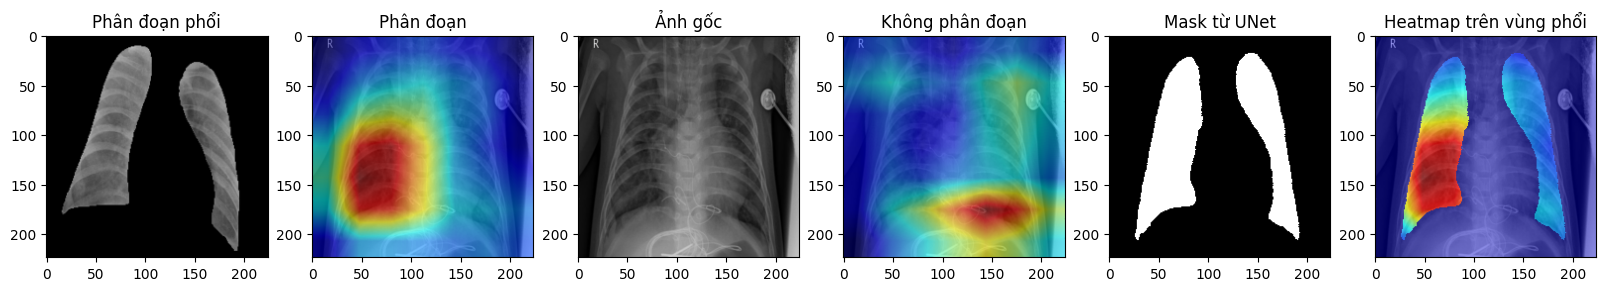

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


100%|██████████| 120/120 [03:53<00:00,  1.94s/it]


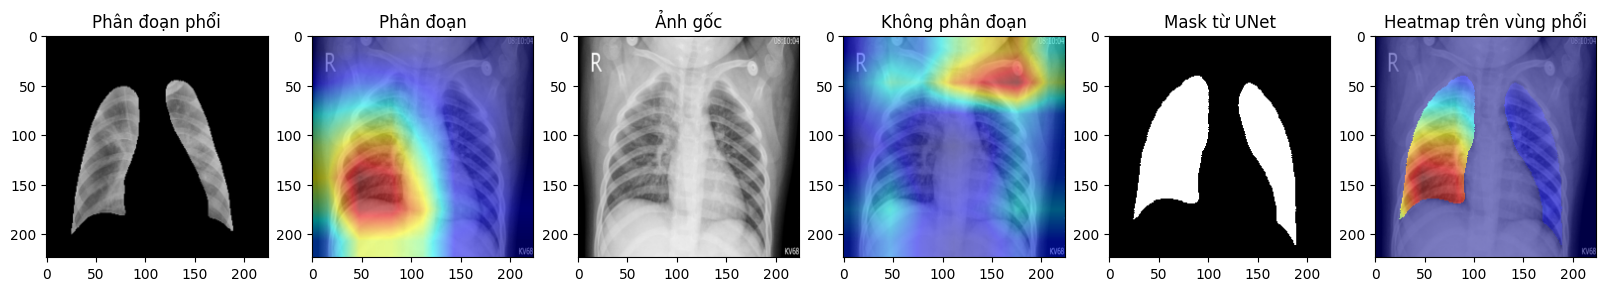

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


100%|██████████| 120/120 [03:32<00:00,  1.77s/it]


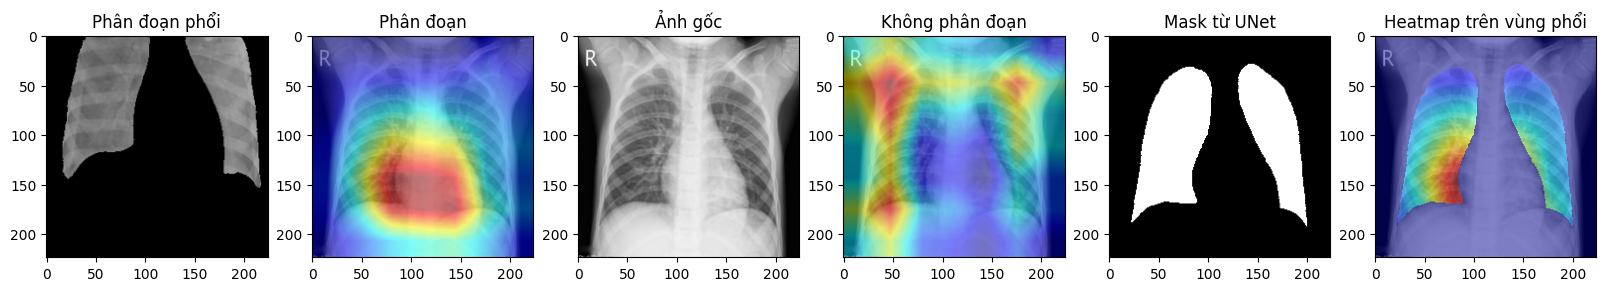

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


100%|██████████| 120/120 [03:06<00:00,  1.55s/it]


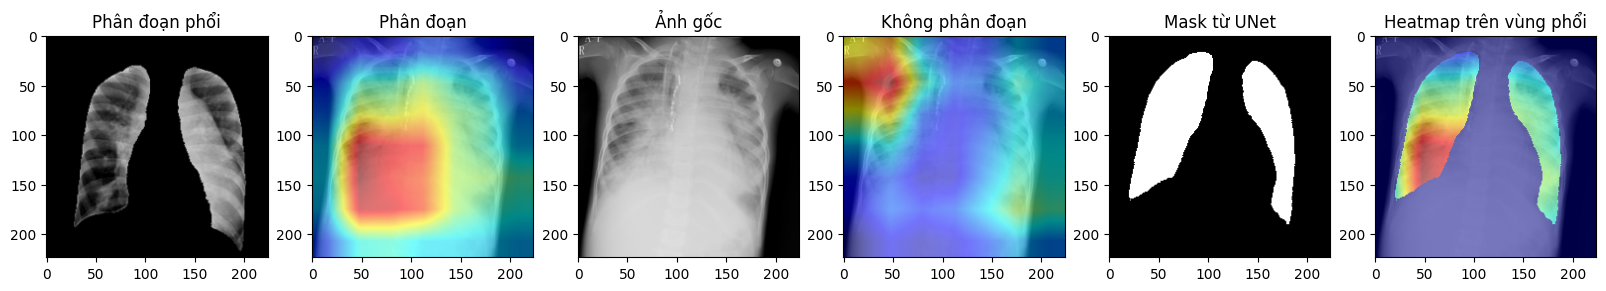

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|██████████| 120/120 [03:11<00:00,  1.59s/it]


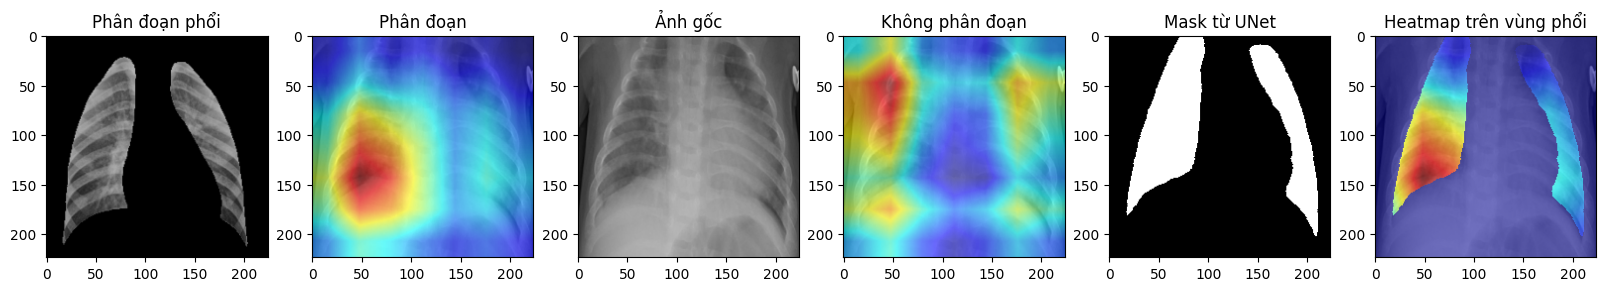

In [17]:
from torchvision import transforms
from PIL import Image
import torch
from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import cv2
from tensorflow.keras.models import load_model

unet_model = load_model('/kaggle/input/segment_model/tensorflow2/default/1/xray_segmentation_model.h5')  # đổi tên file nếu khác



# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

dir1 = '/kaggle/input/segmented-pneumonia/segmented_chest_xray_pneumonia/pneumonia'
image1 = os.listdir(dir1)

dir2 = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA'
image2 = os.listdir(dir2)

samples = image1[:5]
samples2 = image2[:5]

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def get_unet_mask(image_pil, model, input_size=(256, 256)):
    img = image_pil.convert('L')  # Chuyển sang grayscale
    img_resized = img.resize(input_size)
    img_array = np.array(img_resized) / 255.0
    img_input = np.expand_dims(np.expand_dims(img_array, axis=-1), axis=0)  # (1, 256, 256, 1)

    prediction = model.predict(img_input)[0]
    mask = (prediction > 0.5).astype(np.uint8).squeeze()  # Binary mask
    mask_resized = cv2.resize(mask, (224, 224))
    return mask_resized


def score_cam(model, n_model, layer, samples, transform=transform):
    model.eval()
    model.to(device)

    n_model.eval()
    n_model.to(device)    
    
    for i in range(len(samples)): # anhr phoi bd
        img_path = os.path.join(dir1, samples[i])
        img = Image.open(img_path).convert('RGB')
        img = transforms.Resize((224, 224))(img)
        input_tensor = transform(img).unsqueeze(0).to(device)


        origin_image = Image.open(os.path.join(dir2, samples2[i])).convert('RGB')
        origin_image = transforms.Resize((224, 224))(origin_image)
        origin_image_tensor = transform(origin_image).unsqueeze(0).to(device)
        origin_image = np.array(origin_image).astype(np.float32) / 255.0

        unet_mask = get_unet_mask(Image.fromarray((origin_image * 255).astype(np.uint8)).resize((224, 224)), unet_model)

        # target_layers = [model.layer4]
        target_layers = [getattr(model, layer)]
        n_target_layers = [getattr(n_model, layer)]
        

        cam = ScoreCAM(model=model, target_layers=target_layers)
        n_cam = ScoreCAM(model=n_model, target_layers=n_target_layers)

        with torch.no_grad():
            outputs = model(input_tensor)
            pred_class = outputs.argmax(dim=1).item()

            n_outputs = n_model(origin_image_tensor)
            n_pred_class = n_outputs.argmax(dim=1).item()
            
            # if pred_class != 1:
            #     continue

        targets = [ClassifierOutputTarget(pred_class)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

        n_targets = [ClassifierOutputTarget(n_pred_class)]
        n_grayscale_cam = n_cam(input_tensor=origin_image_tensor, targets=n_targets)[0]
        
        visualization = show_cam_on_image(origin_image, grayscale_cam, use_rgb=True)
        
        n_visualization = show_cam_on_image(origin_image, n_grayscale_cam, use_rgb=True)

        # giữ lại heatmap trong vùng phổi + tạo visualization chỉ trên phổi
        masked_cam = grayscale_cam * unet_mask  
        masked_visualization = show_cam_on_image(origin_image, masked_cam, use_rgb=True)

        # masked_cam = visualization * np.expand_dims(unet_mask, axis=-1)
        # background_only = origin_image_np * 255 * (1 - np.expand_dims(unet_mask, axis=-1))
        # segment_visualization = masked_cam + background_only
        # segment_visualization = np.clip(segment_visualization, 0, 255).astype(np.uint8)
        

        fig, ax = plt.subplots(1, 6, figsize=(20, 5))
        ax[0].imshow(img)
        ax[0].set_title('Phân đoạn phổi')
        
        ax[1].imshow(visualization)
        ax[1].set_title("Phân đoạn")

        ax[2].imshow(origin_image, cmap='gray')
        ax[2].set_title("Ảnh gốc")
        
        ax[3].imshow(n_visualization)
        ax[3].set_title("Không phân đoạn")

        ax[4].imshow(unet_mask, cmap='gray')
        ax[4].set_title("Mask từ UNet")

        ax[5].imshow(masked_visualization)
        ax[5].set_title("Heatmap trên vùng phổi")

        plt.show()

# Gọi hàm
# score_cam(model, samples)
score_cam(model, n_model, 'features', samples)

In [ ]:
from tensorflow.keras.models import load_model

unet_model = load_model('/kaggle/input/segment_model/tensorflow2/default/1/xray_segmentation_model.h5')  # đổi tên file nếu khác


In [ ]:
from torchvision import transforms
from PIL import Image
import torch
from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import cv2
from tensorflow.keras.models import load_model

unet_model = load_model('/kaggle/input/segment_model/tensorflow2/default/1/xray_segmentation_model.h5')  # đổi tên file nếu khác



# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

dir1 = '/kaggle/input/segmented-pneumonia/segmented_chest_xray_pneumonia/pneumonia'
image1 = os.listdir(dir1)

dir2 = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA'
image2 = os.listdir(dir2)

samples = image1[:1]
samples2 = image2[:1]

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
imagenet_transform = transforms.Compose([
    transforms.ToTensor(),  # Chuyển từ PIL sang tensor (0-1)
    transforms.Normalize(mean,
                         std)
])

def denormalize(img_tensor):
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(img_tensor, 0, 1)

def get_unet_mask(image_pil, model, input_size=(256, 256)):
    img = image_pil.convert('L')  # Chuyển sang grayscale
    img_resized = img.resize(input_size)
    img_array = np.array(img_resized) / 255.0
    img_input = np.expand_dims(np.expand_dims(img_array, axis=-1), axis=0)  # (1, 256, 256, 1)

    prediction = model.predict(img_input)[0]
    mask = (prediction > 0.5).astype(np.uint8).squeeze()  # Binary mask
    mask_resized = cv2.resize(mask, (224, 224))
    return mask_resized

# Create a proper masked visualization
# def create_masked_visualization(img, cam, mask, use_rgb=True, alpha=0.6):
#     """
#     Creates a visualization where:
#     - Original X-ray is shown as background
#     - Semi-transparent heatmap is only applied to lung regions defined by mask
    
#     Args:
#         img: Original image (normalized to 0-1)
#         cam: Grayscale CAM heatmap
#         mask: Binary mask of lung regions
#         use_rgb: Whether to use RGB colormap
#         alpha: Opacity of the heatmap overlay (0-1, lower = more transparent)
#     """
#     # Chuyển ảnh gốc sang định dạng uint8
#     background = (img * 255).astype(np.uint8)
    
#     # Đảm bảo background là ảnh RGB (3 kênh)
#     if len(background.shape) == 2:
#         background = np.stack([background, background, background], axis=2)
    
#     # Chuyển mask thành định dạng 3 kênh
#     mask_3channel = np.stack([mask, mask, mask], axis=2)
    
#     # Cắt phần heatmap từ full_heatmap_visualization theo mask và ghép lên background
#     masked_visualization = np.where(mask_3channel > 0, full_heatmap_visualization, background)
    
#     return masked_visualization
    
def score_cam(model, layer, samples, transform=transform):
    model.eval()
    model = model.to(device)
    
    for i in range(len(samples)):
        # Clear any previous visualizations to free memory
        plt.close('all')
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
        img_path = os.path.join(dir1, samples[i])
        img = Image.open(img_path).convert('RGB')
        img = transforms.Resize((224, 224))(img)
        input_tensor = transform(img).unsqueeze(0).to(device)
        
        # Load and process original image
        origin_image = Image.open(os.path.join(dir2, samples2[i])).convert('RGB')
        origin_image = transforms.Resize((224, 224))(origin_image)
        origin_image_tensor = transform(origin_image).unsqueeze(0).to(device)
        origin_image_np = np.array(origin_image).astype(np.float32) / 255.0
        
        try:
            # Get UNet mask - make sure unet_model is defined globally or passed as param
            unet_mask = get_unet_mask(Image.fromarray((origin_image_np * 255).astype(np.uint8)), unet_model)
            
            # Get the target layer - handle potential attribute error
            try:
                if hasattr(model, layer):
                    target_layers = [getattr(model, layer)]
                else:
                    # Fallback for models where layer isn't directly accessible
                    # This is a simplified example, you might need custom logic
                    target_layers = [model.layer4]
            except Exception as e:
                print(f"Error accessing layer {layer}: {e}")
                continue
                
            # Initialize ScoreCAM
            cam = ScoreCAM(model=model, target_layers=target_layers)
            
            # Get model prediction
            with torch.no_grad():
                outputs = model(input_tensor)
                pred_class = outputs.argmax(dim=1).item()
            
            # Generate heatmap
            targets = [ClassifierOutputTarget(pred_class)]
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
            
            # Create visualizations
            visualization = show_cam_on_image(origin_image_np, grayscale_cam, use_rgb=True)
            
            masked_cam = visualization * np.expand_dims(unet_mask, axis=-1)

            background_only = origin_image_np * 255 * (1 - np.expand_dims(unet_mask, axis=-1))
            segment_visualization = masked_cam + background_only
            segment_visualization = np.clip(segment_visualization, 0, 255).astype(np.uint8)


            
            # masked_visualization = show_cam_on_image(origin_image_np, masked_cam, use_rgb=True)
            # masked_visualization = create_masked_visualization(origin_image_np, grayscale_cam, unet_mask, use_rgb=True)
            
            # Display results
            fig, ax = plt.subplots(1, 5, figsize=(20, 5))

            img_tensor = imagenet_transform(img)
            img_vis = denormalize(img_tensor).permute(1, 2, 0).numpy()
            
            ax[0].imshow(img_vis)
            ax[0].set_title('Phân đoạn phổi')
            ax[1].imshow(visualization)
            ax[1].set_title("Phân đoạn")
            ax[2].imshow(origin_image_np, cmap='gray')
            ax[2].set_title("Ảnh gốc")
            ax[3].imshow(unet_mask, cmap='gray')
            ax[3].set_title("Mask từ UNet")
            ax[4].imshow(segment_visualization)
            ax[4].set_title("Heatmap trên vùng phổi")
            plt.show()
            
            # Clean up to free memory
            del input_tensor, origin_image_tensor, grayscale_cam, visualization, masked_cam, masked_visualization
            
        except Exception as e:
            print(f"Error processing image {samples[i]}: {e}")
            continue
score_cam(trained_model, 'features', samples)

In [ ]:
from torchvision import transforms
from PIL import Image
import torch
from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import cv2



# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

dir1 = '/kaggle/input/segmented-pneumonia/segmented_chest_xray_pneumonia/pneumonia'
image1 = os.listdir(dir1)

dir2 = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA'
image2 = os.listdir(dir2)

samples = image1[:5]
samples2 = image2[:5]

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def get_unet_mask(image_pil, model, input_size=(256, 256)):
    img = image_pil.convert('L')  # Chuyển sang grayscale
    img_resized = img.resize(input_size)
    img_array = np.array(img_resized) / 255.0
    img_input = np.expand_dims(np.expand_dims(img_array, axis=-1), axis=0)  # (1, 256, 256, 1)

    prediction = model.predict(img_input)[0]
    mask = (prediction > 0.5).astype(np.uint8).squeeze()  # Binary mask
    mask_resized = cv2.resize(mask, (224, 224))
    return mask_resized


def score_cam(model, layer, samples, transform=transform):
    model.eval() 
    
    for i in range(len(samples)): # anhr phoi bd
        img_path = os.path.join(dir1, samples[i])
        img = Image.open(img_path).convert('RGB')
        img = transforms.Resize((224, 224))(img)
        input_tensor = transform(img).unsqueeze(0).to(DEVICE)


        origin_image = Image.open(os.path.join(dir2, samples2[i])).convert('RGB')
        origin_image = transforms.Resize((224, 224))(origin_image)
        origin_image_tensor = transform(origin_image).unsqueeze(0).to(DEVICE)
        origin_image = np.array(origin_image).astype(np.float32) / 255.0

        unet_mask = get_unet_mask(Image.fromarray((origin_image * 255).astype(np.uint8)), unet_model)

        # target_layers = [model.layer4]
        target_layers = [getattr(model, layer)]
        

        cam = ScoreCAM(model=model, target_layers=target_layers)

        with torch.no_grad():
            outputs = model(input_tensor)
            pred_class = outputs.argmax(dim=1).item()

            # if pred_class != 1:
            #     continue

        targets = [ClassifierOutputTarget(pred_class)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

        
        visualization = show_cam_on_image(origin_image, grayscale_cam, use_rgb=True)
        

        # giữ lại heatmap trong vùng phổi + tạo visualization chỉ trên phổi
        masked_cam = grayscale_cam * unet_mask  
        masked_visualization = show_cam_on_image(origin_image, masked_cam, use_rgb=True)


        fig, ax = plt.subplots(1, 6, figsize=(20, 5))
        ax[0].imshow(img)
        ax[0].set_title('Phân đoạn phổi')
        
        ax[1].imshow(visualization)
        ax[1].set_title("Phân đoạn")

        ax[2].imshow(origin_image, cmap='gray')
        ax[2].set_title("Ảnh gốc")
        
        # ax[3].imshow(n_visualization)
        # ax[3].set_title("Không phân đoạn")

        ax[4].imshow(unet_mask, cmap='gray')
        ax[4].set_title("Mask từ UNet")

        ax[5].imshow(masked_visualization)
        ax[5].set_title("Heatmap trên vùng phổi")

        plt.show()

# Gọi hàm
# score_cam(model, samples)
score_cam(trained_model, 'features', samples)

In [ ]:
import gc

# Sau khi xóa biến
gc.collect()
torch.cuda.empty_cache()


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load model
model = load_model('/kaggle/input/segment_model/tensorflow2/default/1/xray_segmentation_model.h5')  # đổi tên file nếu khác

# Load ảnh cần test
image_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0115-0001.jpeg'  # đổi đường dẫn tới ảnh cần test
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Resize ảnh về kích thước input của model (ví dụ 128x128)
input_size = (256, 256)  # thay đổi nếu model Linh dùng kích thước khác
img_resized = cv2.resize(img, input_size)
img_input = img_resized / 255.0  # chuẩn hóa về [0,1]
img_input = np.expand_dims(img_input, axis=-1)
img_input = np.expand_dims(img_input, axis=0)  # thêm batch dimension

# Dự đoán
prediction = model.predict(img_input)[0]

# Ngưỡng hóa (nếu là binary segmentation)
mask = (prediction > 0.5).astype(np.uint8)

# Resize lại mask về kích thước gốc để hiển thị
# mask_resized = cv2.resize(mask, (img.shape[1], img.shape[0]))


# Hiển thị ảnh gốc và mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Ảnh gốc")
plt.imshow(cv2.resize(img, (224,224)))

plt.subplot(1, 2, 2)
plt.title("Mask dự đoán")
plt.imshow(cv2.resize(mask, (224,224)), cmap='gray')

plt.tight_layout()
plt.show()


In [ ]:
def score_cam(model, n_model, target_layer_name, samples, transform=transform):
    model.eval().to(device)
    n_model.eval().to(device)

    for i in range(len(samples)):
        # Ảnh phân đoạn
        img_path = os.path.join(dir1, samples[i])
        img = Image.open(img_path).convert('RGB')
        input_tensor = transform(img).unsqueeze(0).to(device)

        # Ảnh không phân đoạn (cùng index)
        n_img_path = os.path.join(dir2, samples2[i])
        n_img = Image.open(n_img_path).convert('RGB')
        n_input_tensor = transform(n_img).unsqueeze(0).to(device)

        # Chuẩn bị ảnh hiển thị
        origin_image = transforms.Resize((299, 299))(img)
        origin_image = np.array(origin_image).astype(np.float32) / 255.0

        # Layer mục tiêu (phụ thuộc vào model)
        target_layers = [dict([*model.named_modules()])[target_layer_name]]

        # Dùng ScoreCAM
        cam = ScoreCAM(model=model, target_layers=target_layers)

        with torch.no_grad():
            pred_class = model(input_tensor).argmax(dim=1).item()
            n_pred_class = n_model(n_input_tensor).argmax(dim=1).item()

            # Bỏ qua nếu dự đoán không đúng
            if pred_class != 0 or n_pred_class != 0:
                continue

        targets = [ClassifierOutputTarget(pred_class)]
        cam_image = cam(input_tensor=input_tensor, targets=targets)[0]
        n_cam_image = cam(input_tensor=n_input_tensor, targets=targets)[0]

        # CAM overlay
        visualization = show_cam_on_image(origin_image, cam_image, use_rgb=True)
        n_visualization = show_cam_on_image(origin_image, n_cam_image, use_rgb=True)

        # Hiển thị
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(origin_image)
        ax[0].set_title('Ảnh gốc')

        ax[1].imshow(visualization)
        ax[1].set_title("Phân đoạn")

        ax[2].imshow(n_visualization)
        ax[2].set_title('Không phân đoạn')

        for a in ax: a.axis('off')
        plt.tight_layout()
        plt.show()
score_cam(model, n_model, 'features', samples)


In [ ]:
dir1 = '/kaggle/input/segmented-pneumonia/segmented_chest_xray_pneumonia/normal'
image1 = os.listdir(dir1)

dir2 = '/kaggle/input/chest-xray-pneumonia/'
image2 = os.listdir(dir2)

samples = image1[:5]
samples2 = image2[:5]

samples2

In [ ]:
torch.save(model, 'resnet18_default.pth')

In [ ]:
densenet121 = torch.load('/kaggle/input/vgg19/pytorch/default/1/Densenet121.pth')


In [ ]:
densenet121